In [1]:
import os
import numpy as np
import pandas as pd

DIR = "../data/Raw/logRaws/"

NUM_SAMPLES = 2662
NUM_FEATURES = 1
NUM_FRAMES = 1000

file_names = os.listdir(DIR)
input_array = np.empty((NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES))

# prepare data
def read_files(DIR):
    all_files = os.listdir(DIR)

    input_data = np.empty((0, 1), float)

    for file in all_files:
        file_path = os.path.join(DIR, file)
        df = pd.read_csv(file_path, usecols=[1, 22], header=None)
        if df.shape[0] < 999:
            continue

        df.columns = ['frame', 'gyro_x']
        df_input = df[['gyro_x']]
        df_input = df_input.astype('float32')

        input_data = np.append(input_data, df_input, axis=0)
    input_data = input_data.reshape(NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES)

    # divide by 16 to normalize
    input_data = input_data / 2000

    return input_data

input_data = read_files(DIR)

input_data.shape


(2662, 1000, 1)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Layer, Dropout
)
from tensorflow.keras import Sequential

class CustomPadding(Layer):
    def __init__(self, padding_size, **kwargs):
        super(CustomPadding, self).__init__(**kwargs)
        self.padding_size = padding_size

    def call(self, inputs):
        initial_values = inputs[:, 0:1, :, :]
        final_values = inputs[:, -1:, :, :]

        initial_padding = tf.tile(initial_values, [1, self.padding_size, 1, 1])
        final_padding = tf.tile(final_values, [1, self.padding_size, 1, 1])

        return tf.concat([initial_padding, inputs, final_padding], axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.padding_size * 2, input_shape[2], input_shape[3])

class RemovePadding(Layer):
    def __init__(self, padding_size, **kwargs):
        super(RemovePadding, self).__init__(**kwargs)
        self.padding_size = padding_size

    def call(self, inputs):
        return inputs[:, self.padding_size:-self.padding_size, :, :]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] - self.padding_size * 2, input_shape[2], input_shape[3])

def create_autoencoder():
    autoencoder = Sequential([
        # Pre-Processing
        Input(shape=(1000, 1)),
        Reshape((1000, 1, 1)),
        CustomPadding(padding_size=10),

        # Encoder
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 1), padding='same'),

        # Decoder
        UpSampling2D((2, 1)),
        Conv2D(8, (3, 3), activation='relu', padding='same'),

        # Post-Processing
        Conv2D(1, (3, 3), activation='tanh', padding='same'),
        RemovePadding(padding_size=10),
        Reshape((1000, 1))
    ])

    return autoencoder

2023-12-14 00:39:04.985468: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-14 00:39:04.989923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 00:39:05.070266: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 00:39:05.072894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 00:39:06.443864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(input_data, test_size=0.2, random_state=42)

# compile autoencoder
autoencoder = create_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# train autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, X_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1000, 1, 1)        0         
                                                                 
 custom_padding (CustomPadd  (None, 1020, 1, 1)        0         
 ing)                                                            
                                                                 
 conv2d (Conv2D)             (None, 1020, 1, 8)        80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 510, 1, 8)         0         
 D)                                                              
                                                                 
 up_sampling2d (UpSampling2  (None, 1020, 1, 8)        0         
 D)                                                              
                                                        

17/17 [==============================] - 0s 6ms/step


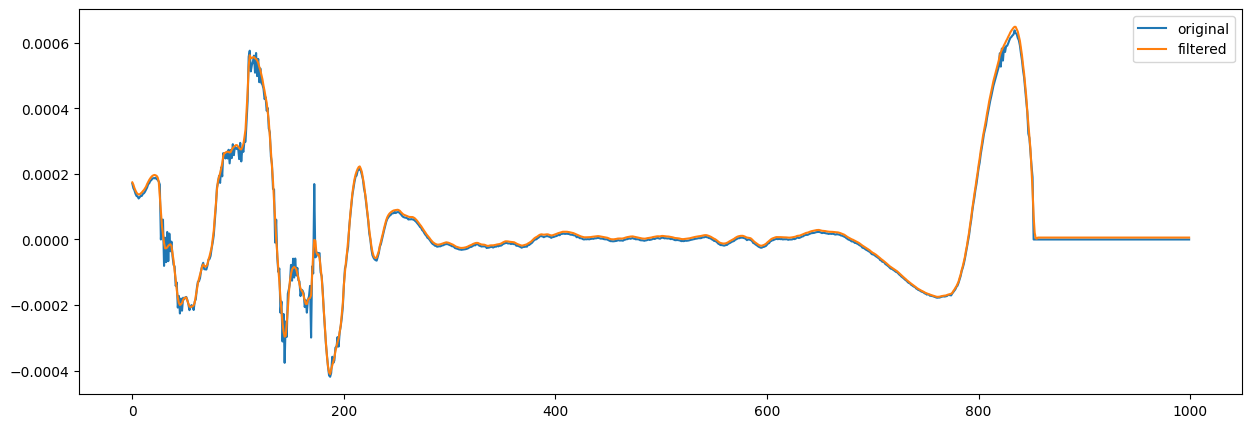

In [4]:
import matplotlib.pyplot as plt

filtered_data = autoencoder.predict(X_test)

INDEX = 48

plt.figure(figsize=(15, 5))
plt.plot(X_test[INDEX])
plt.plot(filtered_data[INDEX])
plt.legend(['original', 'filtered'])
plt.show()


In [5]:
import tensorflow as tf

# save model
export_path = "./autoencoder/single_axis/gyro_x"
tf.saved_model.save(autoencoder, export_path)

INFO:tensorflow:Assets written to: ./autoencoder/single_axis/gyro_x/assets


INFO:tensorflow:Assets written to: ./autoencoder/single_axis/gyro_x/assets
